# Layered Network

##### Imports

In [11]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'modules')))
from hh_model import HodgkinHuxleyNeuron
from layered_network import LayeredNetworkGraph

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

### Single Network

##### Directed Erdos-Renyi Graph

In [12]:
def generate_erdos_renyi_digraph(n, p, s=''):
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Add nodes with custom names
    names = [s + str(i) for i in range(n)]
    for name in names:
        G.add_node(name)  # Assuming HodgkinHuxleyNeuron() is defined elsewhere
    
    # Add edges based on Erdos-Renyi probability
    for i, u in enumerate(names):
        for j, v in enumerate(names):
            if i != j and random.random() < p:
                G.add_edge(u, v)
    
    # Remove bidirectional edges
    for u, v in list(G.edges()):
        if G.has_edge(v, u):
            G.remove_edge(v, u)
    
    # Create neuron objects
    for node in G.nodes():
        G.nodes[node]['neuron'] = HodgkinHuxleyNeuron()
    
    return G

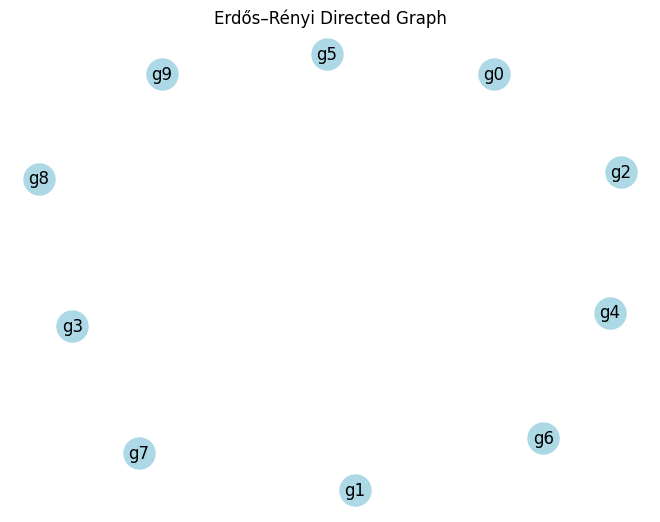

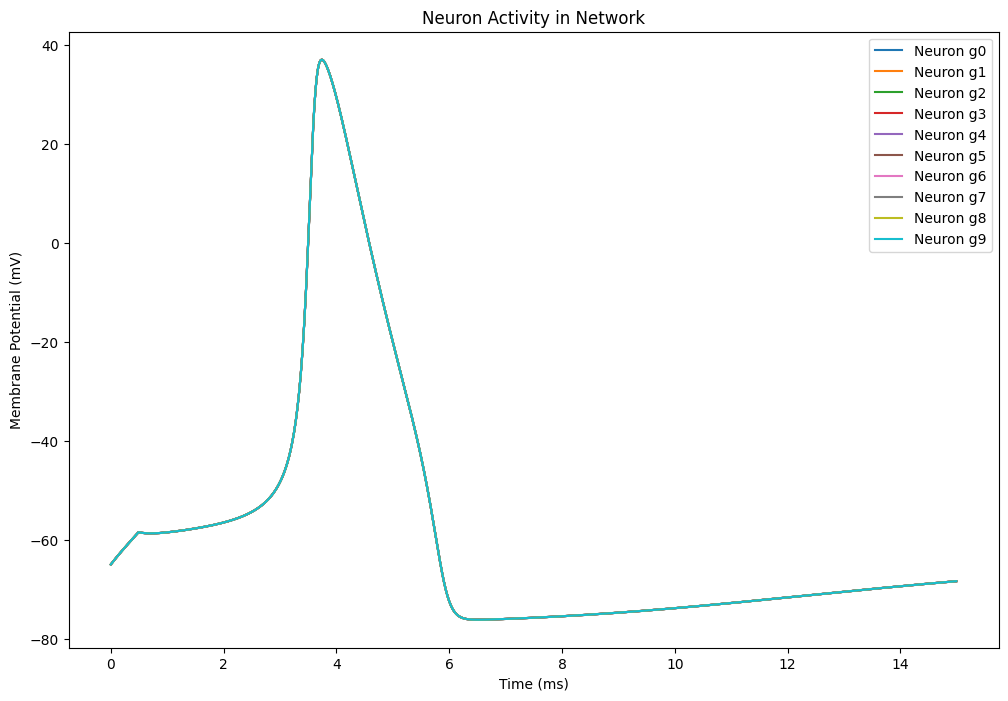

In [13]:
g = generate_erdos_renyi_digraph(10, 0, s='g')

# Draw the graph
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()


# Parameters
T = 15.0
dt = 0.01
time = np.arange(0, T, dt)

I_inp = np.zeros(len(time))
I_inp[int(0/dt):int(0.5/dt)] = 15.0
I_inp[0] = 0

# Record data
V = {}
nodes = g.nodes()
for node in nodes:
        V[node] = []

Network = g.nodes()
for i in range(len(time)):
    for node in Network:
        neuron = Network[node]['neuron']
        neuron.step(dt, I_inp[i])
        V[node].append(neuron.V)


# Plotting results
plt.figure(figsize=(12, 8))
for node, voltages in V.items():
    plt.plot(time, voltages, label=f'Neuron {node}')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Neuron Activity in Network")
plt.show()


In [17]:
# Parameters
n = 10
p = 0.3

# Generate the graph
digraph = generate_erdos_renyi_digraph(n, p)

# Draw the graph
pos = nx.spring_layout(digraph)
nx.draw(digraph, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()

KeyError: 'neuron'

##### Layered Network

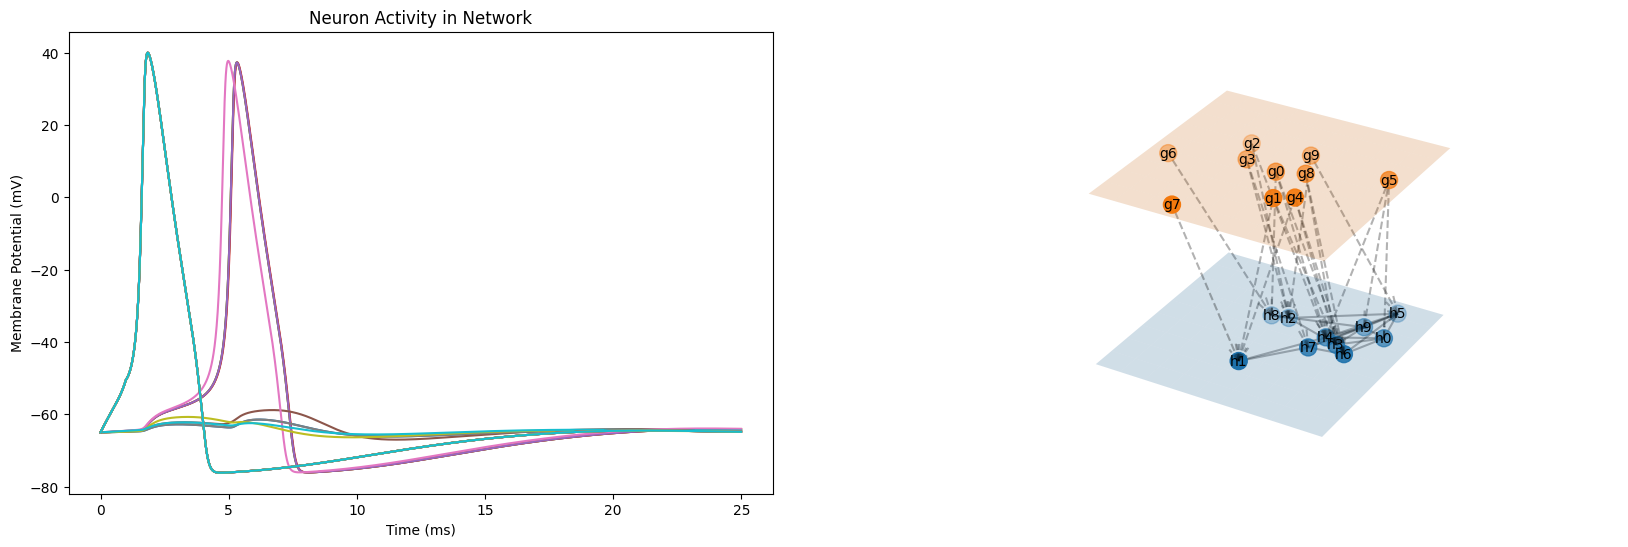

5.256


In [15]:
 # define graphs
n = 10
p = 0.5
prob_inter = 0.2

T = 25
dt = 0.01
obj = LayeredNetworkGraph(
    [(n, 0, 'g'), (n, p, 'h')], T, dt, inter_prob=prob_inter, verbose=True)
a = obj.run()
print(a)